# AnyoneAI - Project II

# Making Estimations with our NBA dataset

In our first project, we learn how to create our own datasets by using a public API, Python and Pandas. We're now going to explore how to make predictive models for regression and classification tasks using ScikitLearn

The goals of this project are:
- Learn how to define a prediction task
- Selecting evaluation metrics and baseline models
- Perform feature engineering and standarization
- Training and using predictive models: Univariable and Multivariate Linear Regression, Classification
- Understand how Gradient Descent works by implementing a Linear Regressor in python

## Using Regression Models to Estimate players Salaries

A player's salary can be explained by a lot of factors: 

- Years in the league: NBA contracts are limited in price, players have caps on how much money they make depending on their years playing in the league
- Age: Highly correlated to the previous one, NBA players have a minimun age of 19 years
- Draft position: players out of USA universities are selected each year through a process called draft, in which each team selects a player in a predefined order for 2 rounds (meaning only 60 players are drafted each year). A rookie contract value depends on the draft position. (Undrafted players have to negotiate a salary independently)
- Performance in statistical categories: after the rookie contract, players can negotiate freely with teams, and usually statistical categories like points, rebounds and assists are extremely important.  
- Team: Even though there are limits to what all teams can expend in players salary, they all allocate their resources differently, and can be more willing to pay the penalties incurred by exceeding those limitations.
- Year in which the contract was signed: the mininum and maximum values of contracts possibles in the NBA changes depending on league revenue (television contracts, sponsorships, etc), so if the amount of money the teams make increases, players can negotiate bigger contracts.
- Intangibles: players can be valued also in things that are not easily translated to a statistic, good defensive players might not always have great stats but can be extremely important for a team, the same can be said about veteran players that help young ones to learn and are good locker-room guys.

But we're going to take a simplified approach, we'll try to use the data we already have to make the best estimator possible, and then we will analyze what went right and what could've gone wrong with our results.

### Analyzing our data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
data = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/project2_players_df.csv")
data.dropna(subset=["PTS"], inplace=True)
data.head()

,PERSON_ID,PLAYER_NAME,TEAM_NAME,POSITION,HEIGHT,WEIGHT,COUNTRY,BIRTHDATE,SEASON_EXP,DRAFT_NUMBER,GP,MIN,PTS,REB,AST,STL,BLK,GAME_DATE,Salary,AGE
0,1630173,Precious Achiuwa,Raptors,Forward,203,102,Nigeria,1999-09-19,1,20,115.0,17.3,6.5,5.1,0.8,0.4,0.5,2022-03-06,2711280,"22 years, 5 months, 25 days"
1,203500,Steven Adams,Grizzlies,Center,211,120,New Zealand,1993-07-20,8,12,648.0,26.8,9.3,7.9,1.4,0.9,0.9,2022-03-06,17073171,"28 years, 7 months, 24 days"
2,1628389,Bam Adebayo,Heat,Center,206,116,USA,1997-07-18,4,14,326.0,28.0,13.2,8.2,3.5,1.0,0.9,2022-03-07,28103550,"24 years, 7 months, 26 days"
3,1630583,Santi Aldama,Grizzlies,Forward,211,98,Spain,2001-01-10,0,30,27.0,10.2,3.3,2.4,0.5,0.1,0.3,2022-03-06,1994520,"21 years, 2 months, 6 days"
4,200746,LaMarcus Aldridge,Nets,Center,211,113,USA,1985-07-19,15,2,1073.0,33.7,19.1,8.1,1.9,0.7,1.1,2022-03-06,2641691,"36 years, 7 months, 25 days"


Let's have another look at our previously generated dataset. 

1.1. Plot all players statistics ("PTS", "REB", "AST","STL","BLK") against salary

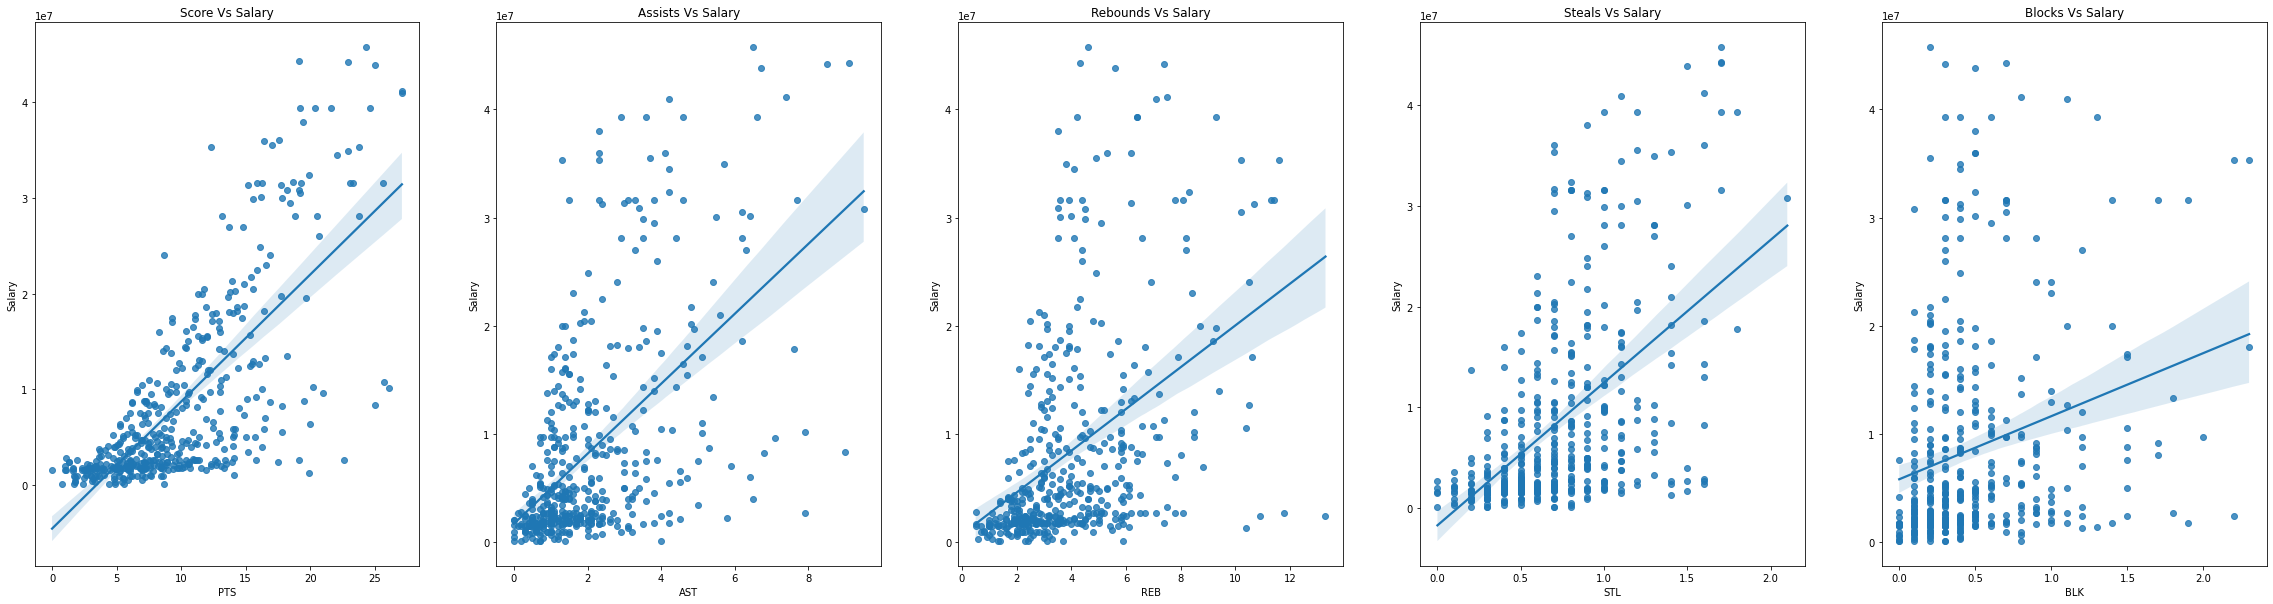

In [68]:
fig, axs = plt.subplots(ncols=5, figsize=(40,10))
sns.regplot(x='PTS', y='Salary', data=data, ax=axs[0]).set(title='Score Vs Salary')
sns.regplot(x='AST', y='Salary', data=data, ax=axs[1]).set(title='Assists Vs Salary')
sns.regplot(x='REB', y='Salary', data=data, ax=axs[2]).set(title='Rebounds Vs Salary')
sns.regplot(x='STL', y='Salary', data=data, ax=axs[3]).set(title='Steals Vs Salary')
sns.regplot(x='BLK', y='Salary', data=data, ax=axs[4]).set(title='Blocks Vs Salary')
plt.show()

1.2. What can we say about these distributions?

They are not linear distributions

### Splitting the Dataset

1.3. Split the dataset into train and testing sets. Use the Sklearn function for train/test splitting. Make sure to set the random state for reproducibility.

In [69]:
X = data['PTS']
y = data['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Baseline Model and Evaluation Metric

In every project, we need a baseline model that implements a very simple algorithm or heuristic so we can compare our results with it. 
In this case, we could create a function that always returns the average player salary, evaluate that, and then compare the result with our modeling to see if we are improving. 

We need an evaluation metric to see how well our models fit the data. For this project we will use [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) as our regression evaluation metric, because it is a really simple metric to interpret. A lower value means the model performs better. 

For this particular problem, we will always round the value, as we don't need decimals for this task.

1.4. Create a Baseline model class that implements  fit() and predict() methods. As this model will not consider any other variable, the fit method should only receive a list of all players salaries. The predict method should receive and iterable and return a numpy array with the same length but every element should have the same value (the average salary)

In [70]:
class BaselineModel():
    """A baseline model that always returns the same value, the mean of the players salary in the train data"""
    
    def fit(self, y_train):
        """
        Fit the training data. 
        
        Parameters
        ----------
        y_train: Union[pd.Series, np.ndarray]
            a pandas series or numpy array containing salary information
        """
        self.promedio = int(round(np.mean(y_train)))
        
    
    def predict(self, X):
        """
        Predict salaries 
        
        Parameters
        ----------
        X: Union[pd.DataFrame, pd.Series, np.ndarray]
            a pandas series, dataframe or numpy array with the 
            
        Returns
        -------
        np.ndarray
            a numpy array of the same length as X, with all elements equal to the mean salary calculated in fit()
        """
        vector_x = np.zeros(len(X))
        vector_x.fill(self.promedio)
        vector_x = vector_x.astype((int))
        return (vector_x)

1.5. Evaluate the performance of our BaselineModel on the test set using mean_absolute_error from Sklearn (round the result)

In [71]:
modelo = BaselineModel()
modelo.fit(y_train)

In [72]:
modelo.predict(X_test)
y_predict = modelo.predict(X_test)
y_predict

array([8602066, 8602066, 8602066, 8602066, 8602066, 8602066, 8602066,
       8602066, 8602066, 8602066, 8602066, 8602066, 8602066, 8602066,
       8602066, 8602066, 8602066, 8602066, 8602066, 8602066, 8602066,
       8602066, 8602066, 8602066, 8602066, 8602066, 8602066, 8602066,
       8602066, 8602066, 8602066, 8602066, 8602066, 8602066, 8602066,
       8602066, 8602066, 8602066, 8602066, 8602066, 8602066, 8602066,
       8602066, 8602066, 8602066, 8602066, 8602066, 8602066, 8602066,
       8602066, 8602066, 8602066, 8602066, 8602066, 8602066, 8602066,
       8602066, 8602066, 8602066, 8602066, 8602066, 8602066, 8602066,
       8602066, 8602066, 8602066, 8602066, 8602066, 8602066, 8602066,
       8602066, 8602066, 8602066, 8602066, 8602066, 8602066, 8602066,
       8602066, 8602066, 8602066, 8602066, 8602066, 8602066, 8602066,
       8602066, 8602066, 8602066, 8602066, 8602066, 8602066, 8602066,
       8602066, 8602066, 8602066, 8602066, 8602066, 8602066, 8602066,
       8602066, 8602

In [73]:
from sklearn.metrics import mean_absolute_error

error = mean_absolute_error(y_test, y_predict)

error = int(round(error))
error

6932349

### Regression with a single variable

You're now going to start modeling data. We will start with a really simple approach, selecting just one variable, and doing a regression to see if we improve upon our baseline.


1.6. Select the variable you think would provide the best fit. Perform feature scaling on this variable using a Sklearn scaler.

<AxesSubplot:xlabel='PTS', ylabel='Count'>

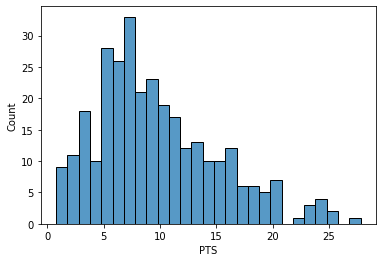

In [74]:
sns.histplot(data= X_train, binwidth=1)

In [75]:
train_minmax = MinMaxScaler().fit(X_train.values.reshape(-1,1))
train_minmax

MinMaxScaler()

In [76]:
X_train = train_minmax.transform(X_train.values.reshape(-1,1))
X_test = train_minmax.transform(X_test.values.reshape(-1,1))

1.7. Train a model with [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) from Sklearn using the default parameters. Evaluate the model's performance on the test set using the selected metric.

1.8. Read the Sklearn documentation, and write a function that tries different configurations for the hyperparameters for training: epochs, learning rate and alpha. For each combination of parameters, evaluate the trained algorithm on the test set, then save the results of each hyperparameter combination, finally select the one that has the best MAE (meaning the lowest number) and print the combination and the MAE.

In [77]:
def search_best_hyperparameters(epochs, learning_rates, alphas):
    result = {
        "hyperparameters": {"epochs": None, "lr": None, "alpha": None}, 
        "mae": None
    }
    # Complete your code here
    return result

In [78]:
# Example list of hyperparameters values
epochs = [1000, 1000000]
learning_rates = [0.0001, 0.001, 0.01, 0.1]
alphas = [0.0001, 0.001, 0.01, 0.1]

result = search_best_hyperparameters(epochs, learning_rates, alphas)
print(result)

{'hyperparameters': {'epochs': None, 'lr': None, 'alpha': None}, 'mae': None}


1.9. Compare the results of the baseline, the SGDRegressor with default parameters and the one with the best combination of hyperparameters you could find. (replace variables with the ones you used)

In [79]:
print("Mean Absolute Error for each model:")
print(f"Baseline: {baseline_mae}")
print(f"Default SGDRegressor: {default_mae}")
print(f"Best SGDRegressor: {best_mae}")

Mean Absolute Error for each model:


NameError: name 'baseline_mae' is not defined

### Multivariate Linear Regression

To improve our model, we will add more features to it. We will have to do some processing to our dataset to be able to use the data.
We'll start with the following variables:

- Points
- Rebounds
- Assists
- Blocks
- Experience
- Position
- Draft Number


1.10. Create a copy of the dataset generated in the first project that only has the following columns (and player id as an index):

["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "SALARY"]

In [42]:
players_c = data[["PTS", "REB", "AST", "BLK", "SEASON_EXP", "POSITION", "DRAFT_NUMBER", "Salary", "PERSON_ID", "TEAM_NAME"]] .copy()
players_c = players_c.set_index('PERSON_ID')
players_c

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,Salary,TEAM_NAME
PERSON_ID,,,,,,,,,
1630173,6.5,5.1,0.8,0.5,1,Forward,20,2711280,Raptors
203500,9.3,7.9,1.4,0.9,8,Center,12,17073171,Grizzlies
1628389,13.2,8.2,3.5,0.9,4,Center,14,28103550,Heat
1630583,3.3,2.4,0.5,0.3,0,Forward,30,1994520,Grizzlies
200746,19.1,8.1,1.9,1.1,15,Center,2,2641691,Nets
...,...,...,...,...,...,...,...,...,...
201152,12.9,5.9,1.8,0.4,14,Forward,12,14190000,Raptors
1629027,25.0,3.9,9.0,0.2,3,Guard,5,8326471,Hawks
1630209,6.0,5.7,1.0,0.4,0,Center,Undrafted,1489065,Heat


#### Feature Engineering

1.11. Perform feature scaling in all the numerical features ("PTS", "REB", "AST", "BLK", "SEASON_EXP") except for draft number (which we will tackle next)

In [43]:
minmaxscal = MinMaxScaler()
columns = players_c[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]].values.reshape(-1, 5)
columns = minmaxscal.fit_transform(columns)
players_c[["PTS", "REB", "AST", "BLK", "SEASON_EXP"]] = columns
players_c

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,Salary,TEAM_NAME
PERSON_ID,,,,,,,,,
1630173,0.239852,0.359375,0.084211,0.217391,0.055556,Forward,20,2711280,Raptors
203500,0.343173,0.578125,0.147368,0.391304,0.444444,Center,12,17073171,Grizzlies
1628389,0.487085,0.601562,0.368421,0.391304,0.222222,Center,14,28103550,Heat
1630583,0.121771,0.148438,0.052632,0.130435,0.000000,Forward,30,1994520,Grizzlies
200746,0.704797,0.593750,0.200000,0.478261,0.833333,Center,2,2641691,Nets
...,...,...,...,...,...,...,...,...,...
201152,0.476015,0.421875,0.189474,0.173913,0.777778,Forward,12,14190000,Raptors
1629027,0.922509,0.265625,0.947368,0.086957,0.166667,Guard,5,8326471,Hawks
1630209,0.221402,0.406250,0.105263,0.173913,0.000000,Center,Undrafted,1489065,Heat


1.12. Binning the DRAFT_NUMBER feature. Draft position directly impacts salaries during the first few years, but second round players and undrafted players don't have guaranteed contracts. So we're gonna divide the bins like this: 

       - 1 to 15: firstround_lottery
       - 15 to 30: firstround_non_lottery
       - 30 to 60: second_round
       - Undrafted: undrafted
       
Create a new column named DRAFT using these 4 categories. Drop the draft number column.

In [44]:
players_c['DRAFT_NUMBER'] = players_c['DRAFT_NUMBER'].replace('Undrafted', 0)
players_c['DRAFT_NUMBER'] = (players_c['DRAFT_NUMBER'].fillna(0)).astype('int64')
players_c

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,Salary,TEAM_NAME
PERSON_ID,,,,,,,,,
1630173,0.239852,0.359375,0.084211,0.217391,0.055556,Forward,20,2711280,Raptors
203500,0.343173,0.578125,0.147368,0.391304,0.444444,Center,12,17073171,Grizzlies
1628389,0.487085,0.601562,0.368421,0.391304,0.222222,Center,14,28103550,Heat
1630583,0.121771,0.148438,0.052632,0.130435,0.000000,Forward,30,1994520,Grizzlies
200746,0.704797,0.593750,0.200000,0.478261,0.833333,Center,2,2641691,Nets
...,...,...,...,...,...,...,...,...,...
201152,0.476015,0.421875,0.189474,0.173913,0.777778,Forward,12,14190000,Raptors
1629027,0.922509,0.265625,0.947368,0.086957,0.166667,Guard,5,8326471,Hawks
1630209,0.221402,0.406250,0.105263,0.173913,0.000000,Center,0,1489065,Heat


In [45]:
players_c['draf_bin'] = pd.cut(players_c['DRAFT_NUMBER'], include_lowest=True,
                               bins=[0, 0.1, 15, 30, 60], labels=['undrafted', 'firstround_lottery',
                                                                       'firstround_non_lottery',
                                                                       'second_round'])
players_c

,PTS,REB,AST,BLK,SEASON_EXP,POSITION,DRAFT_NUMBER,Salary,TEAM_NAME,draf_bin
PERSON_ID,,,,,,,,,,
1630173,0.239852,0.359375,0.084211,0.217391,0.055556,Forward,20,2711280,Raptors,firstround_non_lottery
203500,0.343173,0.578125,0.147368,0.391304,0.444444,Center,12,17073171,Grizzlies,firstround_lottery
1628389,0.487085,0.601562,0.368421,0.391304,0.222222,Center,14,28103550,Heat,firstround_lottery
1630583,0.121771,0.148438,0.052632,0.130435,0.000000,Forward,30,1994520,Grizzlies,firstround_non_lottery
200746,0.704797,0.593750,0.200000,0.478261,0.833333,Center,2,2641691,Nets,firstround_lottery
...,...,...,...,...,...,...,...,...,...,...
201152,0.476015,0.421875,0.189474,0.173913,0.777778,Forward,12,14190000,Raptors,firstround_lottery
1629027,0.922509,0.265625,0.947368,0.086957,0.166667,Guard,5,8326471,Hawks,firstround_lottery
1630209,0.221402,0.406250,0.105263,0.173913,0.000000,Center,0,1489065,Heat,undrafted


1.13. Encode the categorical features: DRAFT, POSITION and TEAM_NAME

In [57]:
players_c = pd.get_dummies(players_c, columns=['DRAFT_NUMBER', 'POSITION', 'TEAM_NAME'])
players_c


,PTS,REB,AST,BLK,SEASON_EXP,Salary,draf_bin,DRAFT_NUMBER_0,DRAFT_NUMBER_1,DRAFT_NUMBER_2,...,TEAM_NAME_Pistons,TEAM_NAME_Raptors,TEAM_NAME_Rockets,TEAM_NAME_Spurs,TEAM_NAME_Suns,TEAM_NAME_Thunder,TEAM_NAME_Timberwolves,TEAM_NAME_Trail Blazers,TEAM_NAME_Warriors,TEAM_NAME_Wizards
PERSON_ID,,,,,,,,,,,,,,,,,,,,,
1630173,0.239852,0.359375,0.084211,0.217391,0.055556,2711280,firstround_non_lottery,0,0,0,...,0,1,0,0,0,0,0,0,0,0
203500,0.343173,0.578125,0.147368,0.391304,0.444444,17073171,firstround_lottery,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1628389,0.487085,0.601562,0.368421,0.391304,0.222222,28103550,firstround_lottery,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1630583,0.121771,0.148438,0.052632,0.130435,0.000000,1994520,firstround_non_lottery,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200746,0.704797,0.593750,0.200000,0.478261,0.833333,2641691,firstround_lottery,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201152,0.476015,0.421875,0.189474,0.173913,0.777778,14190000,firstround_lottery,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1629027,0.922509,0.265625,0.947368,0.086957,0.166667,8326471,firstround_lottery,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1630209,0.221402,0.406250,0.105263,0.173913,0.000000,1489065,undrafted,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Modeling

1.14. Split the dataset into train and test

In [103]:
players_x = players_c.drop(['Salary', 'draf_bin'], axis=1)
players_y = players_c['Salary'].copy()
X_train, X_test, y_train, y_test = train_test_split(players_x, players_y, test_size=0.2, random_state=42)


In [107]:
X_train

,PTS,REB,AST,BLK,SEASON_EXP,DRAFT_NUMBER_0,DRAFT_NUMBER_1,DRAFT_NUMBER_2,DRAFT_NUMBER_3,DRAFT_NUMBER_4,...,TEAM_NAME_Pistons,TEAM_NAME_Raptors,TEAM_NAME_Rockets,TEAM_NAME_Spurs,TEAM_NAME_Suns,TEAM_NAME_Thunder,TEAM_NAME_Timberwolves,TEAM_NAME_Trail Blazers,TEAM_NAME_Warriors,TEAM_NAME_Wizards
PERSON_ID,,,,,,,,,,,,,,,,,,,,,
201152,0.476015,0.421875,0.189474,0.173913,0.777778,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1628969,0.402214,0.265625,0.221053,0.260870,0.166667,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1630224,0.557196,0.210938,0.252632,0.086957,0.000000,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
200794,0.494465,0.515625,0.231579,0.434783,0.833333,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1630217,0.483395,0.250000,0.221053,0.130435,0.055556,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201942,0.763838,0.304688,0.410526,0.130435,0.666667,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1630231,0.332103,0.312500,0.126316,0.260870,0.055556,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1626181,0.416974,0.164062,0.157895,0.130435,0.333333,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


1.15. Write a function to train a SGDRegressor model with the new dataset, trying different hyperparameters, and selecting the one that performs the best.

In [104]:
from sklearn.linear_model import SGDRegressor
X_train

,PTS,REB,AST,BLK,SEASON_EXP,DRAFT_NUMBER_0,DRAFT_NUMBER_1,DRAFT_NUMBER_2,DRAFT_NUMBER_3,DRAFT_NUMBER_4,...,TEAM_NAME_Pistons,TEAM_NAME_Raptors,TEAM_NAME_Rockets,TEAM_NAME_Spurs,TEAM_NAME_Suns,TEAM_NAME_Thunder,TEAM_NAME_Timberwolves,TEAM_NAME_Trail Blazers,TEAM_NAME_Warriors,TEAM_NAME_Wizards
PERSON_ID,,,,,,,,,,,,,,,,,,,,,
201152,0.476015,0.421875,0.189474,0.173913,0.777778,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1628969,0.402214,0.265625,0.221053,0.260870,0.166667,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1630224,0.557196,0.210938,0.252632,0.086957,0.000000,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
200794,0.494465,0.515625,0.231579,0.434783,0.833333,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1630217,0.483395,0.250000,0.221053,0.130435,0.055556,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201942,0.763838,0.304688,0.410526,0.130435,0.666667,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1630231,0.332103,0.312500,0.126316,0.260870,0.055556,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1626181,0.416974,0.164062,0.157895,0.130435,0.333333,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
sgd_reg = SGDRegressor()
sgd_reg.fit(X_train, y_train)


SGDRegressor()

1.16. How did the model performed compared to our univariate models? 

In [106]:
from sklearn.model_selection import GridSearchCV
epochs = [10000, 5000, 1000]
penalty = ['l2', 'l1', 'elasticnet']
loss = ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
def search_best_hyperparameters(train, train_labels, model, epochs, learning_rates, alphas):
    result = {
        "hyperparameters": None,
        "mae": None
    }
    # Complete your code here
    param_grid = [
        {"max_iter": epochs , "penalty": penalty, "loss": loss}
    ]
    grid_search = GridSearchCV(model, param_grid, cv=10, scoring='neg_mean_squared_error', return_train_score=True)
    grid_search.fit(train, train_labels.ravel())

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    result.update({'hyperparameters': best_params, 'mae': best_score})

    return result

In [101]:
result = search_best_hyperparameters(X_train, y_train, sgd_reg, epochs, penalty, loss)
result

C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
C:\Users\Mengo\anaconda3\envs\Python Projects\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1503: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improv

{'hyperparameters': {'eta0': 0.001, 'max_iter': 1500},
 'mae': -48879769241763.23}

### DecisionTreeRegressor

It is possible that this problem might not be easily resolvable by a linear model, or that there could be better types of algorithms to tackle it. As an example, let's try with a very used algorithm, a Decision Tree.



1.17. Create new model using [DecisionTreeRegressor](https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) from scikit learn. We will use again all variables, and try different configuration for the following hyperparameters:

- max_depth
- min_samples_leaf
- max_features

These are all regularization hyperparameters for this algorithm. Read the documentation to get a better grasp of what each one does.

In [ ]:
# List of hyperparameter example values
max_depth = [5, 10, 15, 20, 50]
min_samples_leaf = [2, 10, 20, 50]
max_features = [5, 10]

1.18. Compare the results obtained with the best decision tree model against the baseline, default and the best params sgd regressors-

### Analyzing our results

Based on what you found, and what you read about players salaries above, answer the following: 

1.19. Which kind of model worked better in this dataset, linear or non linear models? Do you have any hypothesis about why? 

1.20. Is there something else we could do to improve our results if wanted to make a more accurate model?

## Star or no Star? Predicting players All-NBA selections

In this section we're going to try to solve a different question:

Can we train a model to predict which players are going to be selected to ALL-NBA teams at the end of the season? This is a [binary classification](https://en.wikipedia.org/wiki/Binary_classification) task, so we're training our first classifier model to solve this problem.

Consider that:

- Being selected as part of the [All-NBA teams](https://en.wikipedia.org/wiki/All-NBA_Team) is different than being selected for [All-Star Game](https://en.wikipedia.org/wiki/NBA_All-Star_Game). 
- You're trying to predict All-NBA selections, which takes place after the regular season but before playoffs start, so we're only going to use players and teams statistics about the regular season (you're not going to consider if the players got to the NBA finals for example). 
- All Star game takes place at the middle point of the regular season, players are selected based on partial season performance, and the general public has 50% of the votes, so it is also a more popularity-based award.
- All-NBA teams are divided in first, second and third teams of 5 players each, divided by position: 2 front court players (guards), 2 backcourt players (forwards) and 1 center.
- As only 15 players are selected to All-NBA teams each year (out of more than 400 qualifying players), our dataset is going to be imbalanced. You're going to have to find a good strategy to deal with this inbalance.

### Analyzing the data

To do this task, you're going to need historical information about All-NBA selections. We'll use a dataset that contains information about players from season starting in 1990 and ending in the 2018-2019 season.
The dataset contains statistics for all players, and a column named "all-nba" that is going to be our target variable, 1 means the player was selected to an All-NBA team that season.


2.1. Load the dataset "all_nba_1990_2017_dataset.csv" from disk, look at the data inside it and print:
- number of rows
- number of seasons
- number of unique players
- number of all-nba selections vs non selected 

In [ ]:
all_nba_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_1990_2017_dataset.csv", index_col=0)

### Splitting the dataset

2.2. Split the dataset in training and test sets. Make sure to keep the distribution of values in the target variable.

Use columns: 'team', 'games', 'games_started', 'mp', 'fg_perc', '3p_perc',
       '2p_perc', 'ft_perc', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts','all_nba'
       
    

### Baseline model and Evaluation Metrics

In this oportunity we'll define our baseline model as the model we can train with the minimun amount of work on the dataset. For this you're gonna train a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) with default parameters, and without doing any preprocessing to our data.

2.3. Let's start with a simple test. What accuracy would we get if we had a baseline model that always predicted 0 (player not selected to all nba)?

2.4. What does this tells us about the data and the use of accuracy as an evaluation metric?

2.5. Scale all numerical features in the dataset (we will keep this scaling for future modeling, so make sure to do it in place

2.6. Train a LogisticRegression with default parameters, use only the numerical features (omit the team information for now). This will be our baseline model. 

2.7. Evaluate our baseline model using this metrics: 

    - accuracy
    - precision
    - recall
    - f1

From now on, you'll be evaluating you model primarily using the F1 Score metric, but we also want to avoid models that have very low recall. 

### Classification

#### Feature engineering

2.8. One hot encode the Team feature. Make sure to drop the original column.

#### Modeling

2.9. Train a logistic regresion model, find the best hyperparameters for: tols, C and max_iter. Try at least 4 values of each parameter. Remember to select based on f1 score, but report also precision and recall. Save the best performing model to use in the next steps.

#### Evaluating on New Data

You're now going to evaluate the results on a test dataset that has not being used to train or do hyperparameter tuning, this is sometimes known as a Test set (in this cases the test set used for training is known as validation set, yeah, it's confusing, but you can read about it [here](https://machinelearningmastery.com/difference-test-validation-datasets/))

2.10. Load the dataset [all_nba_2018_dataset.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv) in one dataframe and [all_nba_2018_selections.csv](https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv)) in another, then:

    - Scale the numerical features. Columns season_id, player_id, player_season, player, season and season_start will not be used for prediction, you can keep them but remember not to pass them to the classifier.
    
    - Create the one hot encoded features for team. This step will be complex, as you will have to consider that in the 2018 season there are 30 teams, but the previous dataset contains 40 teams, that is because a lot of teams changed names or cities over the years. You need to add those 10 different team names in this dataset (with all values in 0) to make the classifier work.

In [ ]:
all_nba_2018_df = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_dataset.csv", index_col=0)
all_nba_2018_selections = pd.read_csv("https://raw.githubusercontent.com/anyoneai/notebooks/main/datasets/all_nba_2018_selections.csv", index_col=0)

2.11. Predict and evaluate the model using precision, recall and f1 score. 

2.12. Analyze the results, what do you think it is happening?

#### Creating our custom Classifier

One thing to consider in this problem, is that the number of ALl NBA selections is fixed each year, a total of 15 players are always selected. But our current model does not limit the number of positive classified players. So, we will have to wrap our model in a custom classifier that only returns as positive the 15 players with the higher probabilities. 
Fortunately, our chosen model provides access to the underlying probabilities.

2.13. Using the trained model, predict probabilities for all rows in the dataset, and create a new column that has the probability that the player was selected as all nba. Round the probability to 3 decimals.

2.14. Sort the dataset by probabilities and show the 15 players with higher probability to have been selected

2.15. Print:

    - Players actually selected from the all_nba_2018_selections dataset,
    - Players actually selected missing from OUR predictions+
    - Players in our predictions not selected 

2.16. Create a class named AllNbaSingleSeasonClassifier that takes a scikit learn model in the constructor, then implements a predict method that returns predictions with only the 15 most probable selections.

In [ ]:
class AllNbaSingleSeasonClassifier():
    def __init__(self, model):
        """
        Class constructor
        
        Parameters
        ----------
        model: BaseEstimator
            a Scikit learn estimator
        """
        self._model = model
        
    def predict(X):
        """
        Predicts all nba selections. This classifier will limit the number
        of positive instances to 15
        
        Parameters
        ----------
        X: pd.DataFrame
            a dataframe with the players data
            
        Returns
        -------
        np.ndarray
            An array of the same length as y, with 15 true results based on the players with most probabilities of
            beign selected
        """

        

2.17. Use the new classifier to make predictions and evaluate the result with precision, recall and f1

#### Analyzing our results

2.18. What do you think it is the main problem with this dataset and the way we trained our model?

2.19. What do you think we could do to improve our model?

### Optional: Oversampling

2.19. Read about oversampling techniques, for example [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html). Use this strategy to create synthetic data and retrain our model. Compare the results. 

## Optional: Developing a Linear Regressor class from scratch

Our last task will be to code a Linear Regression algorithm using Gradient Descent as its optimization algorithm in Python. The structure of the class is presented below, you should use numpy for numerical computation.

3.1. Write a LinearRegression class that implements fit and predict methods, and uses gradient descent as optimization algorithm

In [ ]:
    
class LinearRegressor:
    """Linear regression algorithm class. Implements gradient descent as optimization algorithm"""
    
    def __init__(self, epochs: int, learning_rate: float):
        """
        Class constructor
        
        Parameters
        ----------
        epochs: int
            number of epochs to run gradient descent
        learning_rate: float
            rate of update of the gradients
        """


    def _gradient_descent():
        """
        Gradient descent algorithm
        """


    def fit(self, X, y):
        """
        Fit the model according to the given training data.
        
        Parameters
        ----------
        X: np.ndarray
        y: np.ndarray
        """
             
    def predict(self, X):
        """
        Predict
        
        Parameters
        ----------
        X: np.ndarray
        
        Returns
        -------
        np.ndarray
            array with predictions
        """


3.2. Train a regression model with the data from the first section to calculate players salaries using points per game. Try with a few different values (3 or 4 for each should suffice) for epochs and learning rate parameters, calculate MAE for all results and save the best result along with the parameters values used.

3.3. Evaluate the model performance on the test set, and compare with the result you obtained using SGDRegressor from scikit-learn.